## <b> Convolutional Neural Network for Brain Tumor Detection and Diagnosis (Pytorch, F1-score: 0.97) </b>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !cp -r /content/drive/MyDrive/my_backup/archive /content/

In [3]:
import sys
print(sys.executable)
!{sys.executable} -m pip install tabulate
!{sys.executable} -m pip install ipywidgets jupyterlab_widgets widgetsnbextension tqdm

c:\Users\ysaiv\AppData\Local\Programs\Python\Python311\python.exe


In [4]:
!pip install split-folders
!pip install torch-summary
!pip install tabulate

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [5]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import copy # A module that provides functions for creating copies of objects, useful for avoiding unintended modifications to variables.
import os # A module that provides a way to interact with the operating system, allowing for tasks such as file and directory manipulation.
import torch
from PIL import Image # A module from the Python Imaging Library (PIL) that provides functionality for opening, manipulating, and saving various image file formats.
from torch.utils.data import Dataset # A PyTorch class that represents a dataset and provides an interface for accessing and processing the data during training.
import torchvision
import torchvision.transforms as transforms # A module from the torchvision library that provides common image transformations, such as resizing, cropping, and normalization.
from torch.utils.data import random_split # A function from PyTorch that allows for randomly splitting a dataset into training and validation subsets.
from torch.optim.lr_scheduler import ReduceLROnPlateau # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.
import torch.nn as nn # A module in PyTorch that provides classes for defining and building neural networks.
from torchvision import utils # A module from torchvision that contains utility functions for working with images, such as saving and visualizing them.
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools # This import statement imports the itertools module, which provides functions for efficient looping and combining of iterables. It can be used for tasks such as generating combinations or permutations of elements.
#from tqdm.notebook import trange, tqdm # These functions allow for the creation of progress bars to track the progress of loops or tasks.
from torch import optim
import warnings
warnings.filterwarnings('ignore')

In [6]:
from IPython.core.display import display, HTML, Javascript

color_map = ['#FFFFFF','#FF5733']

prompt = color_map[-1]
main_color = color_map[0]
strong_main_color = color_map[1]
custom_colors = [strong_main_color, main_color]

css_file = '''
div #notebook {
background-color: white;
line-height: 20px;
}

#notebook-container {
%s
margin-top: 2em;
padding-top: 2em;
border-top: 4px solid %s;
-webkit-box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5);
    box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5);
}

div .input {
margin-bottom: 1em;
}

.rendered_html h1, .rendered_html h2, .rendered_html h3, .rendered_html h4, .rendered_html h5, .rendered_html h6 {
color: %s;
font-weight: 600;
}

div.input_area {
border: none;
    background-color: %s;
    border-top: 2px solid %s;
}

div.input_prompt {
color: %s;
}

div.output_prompt {
color: %s;
}

div.cell.selected:before, div.cell.selected.jupyter-soft-selected:before {
background: %s;
}

div.cell.selected, div.cell.selected.jupyter-soft-selected {
    border-color: %s;
}

.edit_mode div.cell.selected:before {
background: %s;
}

.edit_mode div.cell.selected {
border-color: %s;

}
'''

def to_rgb(h):
    return tuple(int(h[i:i+2], 16) for i in [0, 2, 4])

main_color_rgba = 'rgba(%s, %s, %s, 0.1)' % (to_rgb(main_color[1:]))
open('notebook.css', 'w').write(css_file % ('width: 95%;', main_color, main_color, main_color_rgba,
                                            main_color,  main_color, prompt, main_color, main_color,
                                            main_color, main_color))

def nb():
    return HTML("<style>" + open("notebook.css", "r").read() + "</style>")
nb()


## <b>1 <span style='color:#e61227'>|</span> Introduction</b>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>1.1 |</span></b> Why do we need this study?</b></p>
</div>

**Deep Learning** has emerged as a powerful tool in the field of **medical imaging** and has shown great potential in aiding the health community in the detection and diagnosis of **brain tumors**. By leveraging deep learning algorithms, we can analyze medical images, such as **MRI** or **CT scans**, with unprecedented accuracy and efficiency. Also, it can assist in the classification of brain tumors into different subtypes. By training models on large datasets of labeled brain tumor images, deep learning algorithms can learn to distinguish between various tumor types, such as gliomas, meningiomas, or metastatic tumors. This classification capability can aid in determining the appropriate treatment approach and prognosis for patients.

Overall, deep learning has the potential to revolutionize brain tumor detection and diagnosis. By leveraging the power of neural networks, we can enhance the accuracy, efficiency, and understanding of brain tumor imaging, ultimately leading to improved patient care and outcomes in the field of neuro-oncology.

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>1.2 |</span></b> Problem Statement</b></p>
</div>

The accurate detection and classification of **Brain Tumors** play a crucial role in the diagnosis and treatment planning of patients. However, manual interpretation of **Medical Images** , such as MRI scans, can be time-consuming and subjective, leading to potential errors and delays in patient care. Therefore, there is a need for an automated and reliable method to detect and classify brain tumors from medical images.

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>1.3 |</span></b> Study Aim</b></p>
</div>

This study aims to develop a Convolutional Neural Network **(CNN)** using the **PyTorch** framework that can accurately detect and classify **Brain Tumors** from MRI scans. The CNN will be trained on a large dataset of labeled brain tumor images to learn the patterns and features associated with different tumor types. The study aims to achieve high accuracy in tumor detection and classification, providing a valuable tool for healthcare professionals in the field of neuro-oncology. The ultimate goal is to improve the efficiency and accuracy of brain tumor diagnosis, enabling timely and appropriate treatment planning for patients.

## <b>2 <span style='color:#e61227'>|</span> Dataset</b>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>2.1 |</span></b> Load Dataset</b></p>
</div>

In [7]:
labels_df = pd.read_csv('C:/Education/ASU/Semester_4/CSE598_SLT/Project/archive/metadata.csv')
print(labels_df.head().to_markdown())

|    |   Unnamed: 0 | image           | class   | format   | mode   | shape         |
|---:|-------------:|:----------------|:--------|:---------|:-------|:--------------|
|  0 |            0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 |            1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 |            2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 |            3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 |            4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |


In [8]:
os.listdir('C:/Education/ASU/Semester_4/CSE598_SLT/Project/archive/Brain_Tumor_Dataset/Brain_Tumor_Dataset')

['Brain_Tumor', 'Healthy']

In [9]:
labels_df.shape

(4600, 6)

## <b>3 <span style='color:#e61227'>|</span> Data Preparation </b>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>3.1 |</span></b> Splitting Dataset</b></p>
</div>

- We need to evaluate the model on validation datasets to track the model's performance during training. Then, Let's use 20% of the dataset for the **Validation set** and use the rest as the **Training set**, so we have an **80/20** split!

In [10]:
# Dataset Path
data_dir = 'C:/Education/ASU/Semester_4/CSE598_SLT/Project/archive/Brain_Tumor_Dataset/Brain_Tumor_Dataset'
data_dir = pathlib.Path(data_dir)

# Splitting dataset to train_set, val_set and test_set
splitfolders.ratio(data_dir, output='C:/Education/ASU/Semester_4/CSE598_SLT/Project/archive/Version/brain', seed=20, ratio=(0.8, 0.2))

# New dataset path
data_dir = 'C:/Education/ASU/Semester_4/CSE598_SLT/Project/archive/Version/brain'
data_dir = pathlib.Path(data_dir)

Copying files: 4600 files [00:42, 107.37 files/s]


## <b>4 <span style='color:#e61227'>|</span> Image Augmentation Definitions</b>

In [11]:
# define transformation
transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)

In [12]:
!find /content/brain -type d -name ".ipynb_checkpoints"
!find /content/brain -type d -name ".ipynb_checkpoints" -exec rm -rf {} +


FIND: Invalid switch
FIND: Invalid switch


In [13]:
# Define dataset paths
train_dir = 'C:/Education/ASU/Semester_4/CSE598_SLT/Project/archive/Version/brain/train'
val_dir = 'C:/Education/ASU/Semester_4/CSE598_SLT/Project/archive/Version/brain/val'

# Create ImageFolder datasets
train_set = torchvision.datasets.ImageFolder(train_dir, transform=transform)
val_set   = torchvision.datasets.ImageFolder(val_dir, transform=transform)


In [14]:
!{sys.executable} -m pip install datasets

from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset

bti_dataset = load_dataset("dwb2023/brain-tumor-image-dataset-semantic-segmentation")
image = bti_dataset["train"][0]["image"]
image.show()

In [15]:
print(bti_dataset)

DatasetDict({
    train: Dataset({
        features: ['file_name', 'image', 'id', 'category_id', 'bbox', 'segmentation', 'area', 'iscrowd', 'height', 'width', 'date_captured', 'license'],
        num_rows: 1502
    })
    test: Dataset({
        features: ['file_name', 'image', 'id', 'category_id', 'bbox', 'segmentation', 'area', 'iscrowd', 'height', 'width', 'date_captured', 'license'],
        num_rows: 215
    })
    valid: Dataset({
        features: ['file_name', 'image', 'id', 'category_id', 'bbox', 'segmentation', 'area', 'iscrowd', 'height', 'width', 'date_captured', 'license'],
        num_rows: 429
    })
})


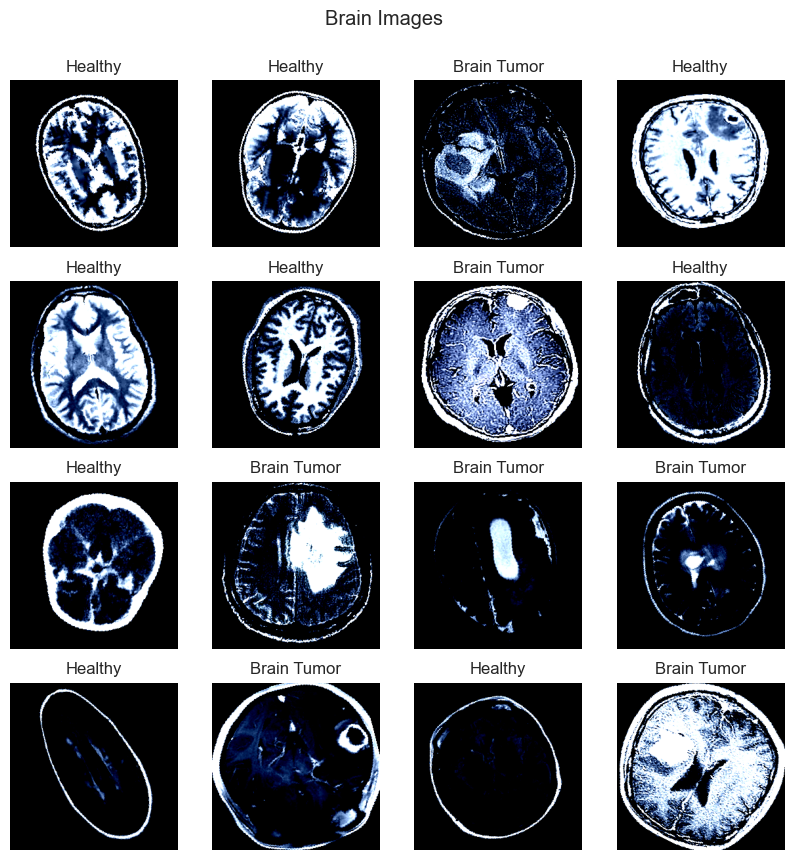

In [16]:
# Visualiztion some images from Train Set
CLA_label = {
    0 : 'Brain Tumor',
    1 : 'Healthy'
}
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Brain Images', y=0.95)
plt.show()

## <b>5 <span style='color:#e61227'>|</span> Creating Dataloaders</b>

In [17]:
# import and load train, validation
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader   = torch.utils.data.DataLoader(val_set,   batch_size = batch_size, shuffle = True, num_workers = 2)

In [18]:
# print shape for Training data and Validation data
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64



## <b>6 <span style='color:#e61227'>|</span> Define Brain Tumor Classifier</b>


In [19]:
'''This function can be useful in determining the output size of a convolutional layer in a neural network,
given the input dimensions and the convolutional layer's parameters.'''

def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [20]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.conv(x) + self.shortcut(x))

In [21]:
# Define Architecture For CNN_TUMOR Model
class CNN_TUMOR(nn.Module):

    # Network Initialisation
    def __init__(self, params):

        super(CNN_TUMOR, self).__init__()

        Cin, H, W = params["shape_in"]
        f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        drop = params["dropout_rate"]

        # Convolution Layers
        self.features = nn.Sequential(
            ResidualBlock(Cin, f),     
            nn.MaxPool2d(2),

            ResidualBlock(f, 2*f),
            nn.MaxPool2d(2),

            ResidualBlock(2*f, 4*f),
            nn.MaxPool2d(2),

            ResidualBlock(4*f, 8*f),
            nn.Dropout2d(0.3),
            nn.AdaptiveAvgPool2d((1, 1))
        )


        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*f, num_fc1),  # still correct after global pooling
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(num_fc1, num_classes)
        )

    def forward(self, X):
        X = self.features(X)
        X = self.classifier(X)
        return X

In [22]:
params_model={
        "shape_in": (3,224,224),
        "initial_filters": 32,
        "num_fc1": 128,
        "dropout_rate": 0.4,
        "num_classes": 2}

# Create instantiation of Network class
cnn_model = CNN_TUMOR(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

In [23]:
# Model Summary for CNN Model
summary(cnn_model, input_size=(3, 256, 256),device=device.type)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─ResidualBlock: 2-1                --
|    |    └─Sequential: 3-1              10,208
|    |    └─Sequential: 3-2              160
|    |    └─ReLU: 3-3                    --
|    └─MaxPool2d: 2-2                    --
|    └─ResidualBlock: 2-3                --
|    |    └─Sequential: 3-4              55,552
|    |    └─Sequential: 3-5              2,176
|    |    └─ReLU: 3-6                    --
|    └─MaxPool2d: 2-4                    --
|    └─ResidualBlock: 2-5                --
|    |    └─Sequential: 3-7              221,696
|    |    └─Sequential: 3-8              8,448
|    |    └─ReLU: 3-9                    --
|    └─MaxPool2d: 2-6                    --
|    └─ResidualBlock: 2-7                --
|    |    └─Sequential: 3-10             885,760
|    |    └─Sequential: 3-11             33,280
|    |    └─ReLU: 3-12                   --
|    └─Dropout2d: 2-8                    -

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─ResidualBlock: 2-1                --
|    |    └─Sequential: 3-1              10,208
|    |    └─Sequential: 3-2              160
|    |    └─ReLU: 3-3                    --
|    └─MaxPool2d: 2-2                    --
|    └─ResidualBlock: 2-3                --
|    |    └─Sequential: 3-4              55,552
|    |    └─Sequential: 3-5              2,176
|    |    └─ReLU: 3-6                    --
|    └─MaxPool2d: 2-4                    --
|    └─ResidualBlock: 2-5                --
|    |    └─Sequential: 3-7              221,696
|    |    └─Sequential: 3-8              8,448
|    |    └─ReLU: 3-9                    --
|    └─MaxPool2d: 2-6                    --
|    └─ResidualBlock: 2-7                --
|    |    └─Sequential: 3-10             885,760
|    |    └─Sequential: 3-11             33,280
|    |    └─ReLU: 3-12                   --
|    └─Dropout2d: 2-8                    -

## <b>7 <span style='color:#e61227'>|</span> Loss Function Definition</b>

In [24]:
loss_func = nn.CrossEntropyLoss(label_smoothing=0.1)

## <b>8 <span style='color:#e61227'>|</span> Optimiser Definition</b>

In [25]:
from torch.optim.lr_scheduler import CosineAnnealingLR

opt = optim.AdamW(cnn_model.parameters(), lr=1e-4, weight_decay=1e-4)
lr_scheduler = CosineAnnealingLR(opt, T_max=20)

## <b>9 <span style='color:#e61227'>|</span> Training Model</b>

In [26]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):

    loss = loss_func(output, target)  # raw logits now (correct)

    pred = output.argmax(dim=1, keepdim=True)
    metric_b = pred.eq(target.view_as(pred)).sum().item()

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):

    run_loss=0.0
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output  # convert to log-probabilities
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b

    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value

    return loss, metric

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>9.2 |</span></b> Training Function</b></p>
</div>


In [27]:
def Train_Val(model, params,verbose=False):

    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]

    # history of loss values in each epoch
    loss_history={"train": [],"val": []}
    # histroy of metric values in each epoch
    metric_history={"train": [],"val": []}
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    # initialize best loss to a large value
    best_loss=float('inf')

# Train Model n_epochs (the progress of training by printing the epoch number and the associated learning rate. It can be helpful for debugging, monitoring the learning rate schedule, or gaining insights into the training process.)

    for epoch in tqdm(range(epochs)):

        # Get the Learning Rate
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))


# Train Model Process


        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)


# Evaluate Model Process


        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)

        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # learning rate schedule
        lr_scheduler.step()
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>9.3 |</span></b> Training Process </b></p>
</div>

In [28]:
!{sys.executable} -m pip install ipywidgets

In [29]:
# Define various parameters used for training and evaluation of a cnn_model
import sys
!{sys.executable} -m pip install ipywidgets jupyterlab_widgets widgetsnbextension

from tqdm import tqdm

params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 60,
 "optimiser": opt,
 "lr_change": lr_scheduler,
 "f_loss": loss_func,
 "weight_path": "weights.pt",
}

# train and validate the model
cnn_model,loss_hist,metric_hist = Train_Val(cnn_model,params_train)

100%|██████████| 60/60 [9:59:39<00:00, 599.65s/it]  


## <b>10 <span style='color:#e61227'>|</span> Evaluation Metric Visualization </b>

<Axes: >

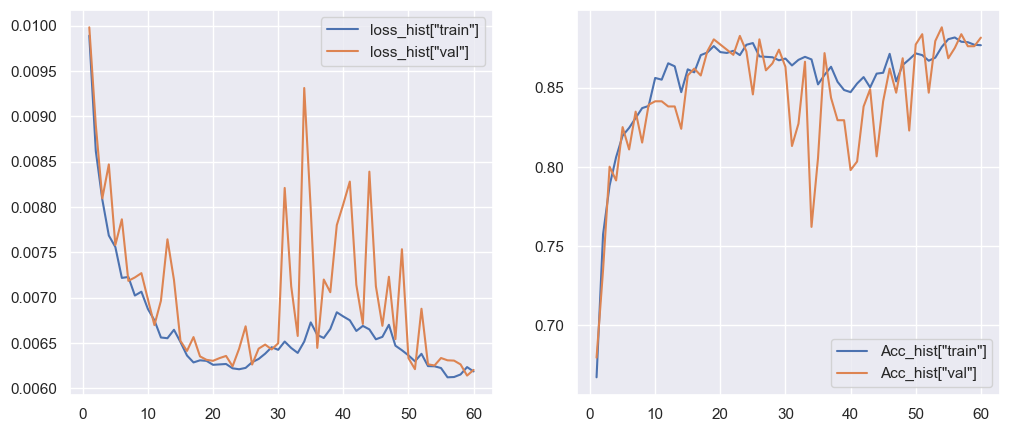

In [30]:
# Convergence History Plot
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='Acc_hist["val"]')

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>10.2 |</span></b> Confusion_Matrix </b></p>
</div>

In [31]:
# define function For Classification Report
def Ture_and_Pred(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()

        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)

    return y_true, y_pred


# check confusion matrix for error analysis
y_true, y_pred = Ture_and_Pred(val_loader, cnn_model)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

         0.0       0.92      0.87      0.89       503
         1.0       0.85      0.91      0.88       418

    accuracy                           0.88       921
   macro avg       0.88      0.89      0.88       921
weighted avg       0.89      0.88      0.89       921
 




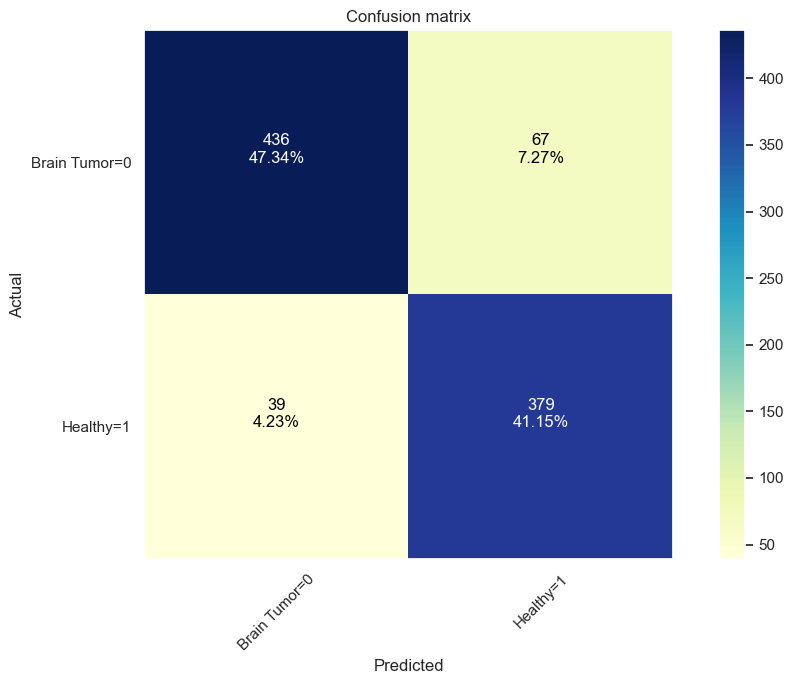

In [32]:
# Confusion Matrix Plotting Function
def show_confusion_matrix(cm, CLA_label, title='Confusion matrix', cmap=plt.cm.YlGnBu):

    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(CLA_label))

    plt.xticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%", horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

show_confusion_matrix(cm, CLA_label)

In [33]:
print(model)

CNN_TUMOR(
  (features): Sequential(
    (0): ResidualBlock(
      (conv): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential(
        (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ResidualBlock(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [34]:
print(bti_dataset)

print("TRAIN labels:", set([x["category_id"] for x in bti_dataset["train"]]))
print("TEST labels:", set([x["category_id"] for x in bti_dataset["test"]]))
print("VALID labels:", set([x["category_id"] for x in bti_dataset["valid"]]))


DatasetDict({
    train: Dataset({
        features: ['file_name', 'image', 'id', 'category_id', 'bbox', 'segmentation', 'area', 'iscrowd', 'height', 'width', 'date_captured', 'license'],
        num_rows: 1502
    })
    test: Dataset({
        features: ['file_name', 'image', 'id', 'category_id', 'bbox', 'segmentation', 'area', 'iscrowd', 'height', 'width', 'date_captured', 'license'],
        num_rows: 215
    })
    valid: Dataset({
        features: ['file_name', 'image', 'id', 'category_id', 'bbox', 'segmentation', 'area', 'iscrowd', 'height', 'width', 'date_captured', 'license'],
        num_rows: 429
    })
})
TRAIN labels: {1, 2}
TEST labels: {1, 2}
VALID labels: {1, 2}


In [35]:
import torch
from torch.utils.data import Dataset, DataLoader

# ----------------------------
# Dataset Class
# ----------------------------
class BTID_Dataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        sample = self.hf_dataset[idx]
        img = sample["image"]
        label = sample["category_id"] - 1  # 0 = tumor, 1 = normal
        if self.transform:
            img = self.transform(img)
        return img, label

# ----------------------------
# Debug: Check labels in all splits
# ----------------------------
for split in ["train", "valid", "test"]:
    labels = [sample["category_id"] for sample in bti_dataset[split]]
    print(f"{split.upper()} labels:", sorted(set(labels)))
    print(f"{split.upper()} num samples:", len(bti_dataset[split]))

# ----------------------------
# Create PyTorch datasets and dataloaders
# ----------------------------
batch_size = 32  # or whatever you used

datasets = {}
dataloaders = {}

for split in ["train", "valid", "test"]:
    print(f"\nCreating dataset and dataloader for {split.upper()}...")
    datasets[split] = BTID_Dataset(bti_dataset[split], transform=transform)
    dataloaders[split] = DataLoader(
        datasets[split],
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )
    print(f"{split.upper()} dataloader length: {len(dataloaders[split])}")

# ----------------------------
# Evaluate model on all splits
# ----------------------------
model.eval()

for split in ["train", "valid", "test"]:
    print(f"\nEvaluating on {split.upper()} split...")
    loader = dataloaders[split]
    try:
        test_loss, test_acc = loss_epoch(model, loss_func, loader)
        print(f"{split.upper()} Accuracy: {test_acc*100:.2f}% | Loss: {test_loss:.4f}")
    except Exception as e:
        print(f"Error during evaluation on {split.upper()}: {e}")


TRAIN labels: [1, 2]
TRAIN num samples: 1502
VALID labels: [1, 2]
VALID num samples: 429
TEST labels: [1, 2]
TEST num samples: 215

Creating dataset and dataloader for TRAIN...
TRAIN dataloader length: 47

Creating dataset and dataloader for VALID...
VALID dataloader length: 14

Creating dataset and dataloader for TEST...
TEST dataloader length: 7

Evaluating on TRAIN split...
TRAIN Accuracy: 70.44% | Loss: 0.0203

Evaluating on VALID split...
VALID Accuracy: 73.43% | Loss: 0.0194

Evaluating on TEST split...
TEST Accuracy: 72.09% | Loss: 0.0207


## <b>11<span style='color:#e61227'>|</span> Save Model </b>

In [36]:
torch.save(cnn_model, "Brain_Tumor_model.pt")